## Housing Prices Index Analysis

### Hypothesis: 
Housing markets across the nation should follow each other. Obviously there will be some divergence from the average in certain locations, but let's investigate if markets return to the index mean. They should be at least correlated in some degree, but we need to test that assumption to be sure.

### Data: 
To steam line things, I'm attempting to utilize Quandl's API for the housing data. What we want to do is find all 50 state's data. To do this we can scrape a Wikipedia list for state names and then populate a dataframe with data queried directly from Quandl. First let's import some necessary modules:

In [1]:
import quandl
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from matplotlib import style

%matplotlib inline
style.use("fivethirtyeight")

Utilizing the API key, we can gather data for Oregon: 

In [2]:
api_key = "UjMPYtm8xWdYKXHD8Fok"
df = pd.DataFrame()
df = quandl.get('FMAC/HPI_OR', authtoken=api_key)

Importantly, if we are trying to understand the analysis of housing markets across the nation, we need data on all 50 states. This shouldn't be that hard. What we can do is gather a simple list of state abbreviations from Wikipedia, so we can run that list through Quandl.

In [3]:
states = pd.read_html("https://simple.wikipedia.org/wiki/List_of_U.S._states", flavor="html5lib")

main_df = pd.DataFrame()
main_df2 = pd.DataFrame()

Now that we have the list, let's populate a dataframe from this list. Since Quandl changed their series titles to _'Value'_ we have to alter the column names as well. 

In [10]:
main_df = pd.DataFrame()

for abrev in states[0][0][1:]:
    query = "FMAC/HPI_" + str(abrev)
    df = quandl.get(query, authtoken=api_key)
    df.columns = [abrev]
    
    if main_df.empty:
        main_df = df
    else:
        main_df = main_df.join(df)

In [11]:
for abrev in states[0][0][1:]:
    query = "FMAC/HPI_" + str(abrev)
    df = quandl.get(query, authtoken=api_key)
    df = df.rename(columns={'Value': abrev})     
    df[abrev] = ((df[abrev] - df[abrev][0]) / df[abrev][0]) * 100.00

    if main_df2.empty:
        main_df2 = df
    else:
        main_df2 = main_df2.join(df)

For ease of replication, we can export the result as Panda Pickle. This allows us to call in the object without having to query Quandl every time. 

In [12]:
#For original dataset
pickle_out = open("states_housing_index.pickle", "wb")
pickle.dump(main_df, pickle_out)
pickle_out.close()

#For percent change dataset
pickle_out = open("percent_change_HPI.pickle", "wb")
pickle.dump(main_df2, pickle_out)
pickle_out.close()

Importing data from the Pickle object:

In [13]:
#Import original dataset
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)

#Import percent change dataset
pickle_in = open("percent_change_HPI.pickle", "rb")
HPI_percent_data = pickle.load(pickle_in)

Also, to understand the `National Average`, we're going to need a series on that as well. Fortunately, we can import Freddie Mac's United States series. Apposed to a period over period percentage change, I'm going to utilize a percent charge from the initial value. This should give us a better understanding of home price inflation since 1975 (creation of the series). Again we can just query Quandl for that:

In [14]:
def HPI_benchmark():
    HPI_bench = pd.DataFrame()
    HPI_bench = quandl.get("FMAC/HPI_USA", authtoken=api_key)
    HPI_bench.columns = ['US_HPI']
    HPI_bench["US_HPI"] = ((HPI_bench["US_HPI"]-HPI_bench["US_HPI"][0]) / HPI_bench["US_HPI"][0]) * 100.0

    return HPI_bench

### Analysis

Now that we have gathered and populated our dataframe, we are good to run analysis! Again, our overall aim is to see if certain state's housing markets diverge from the nation mean. Let's first run some high level manipulations:

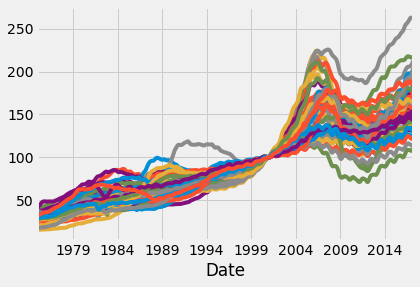

In [47]:
HPI_data.plot()
plt.legend().remove()
plt.show()

Notice how all of the housing prices converge upon the 2000 or 100 mark. This is due to structural erros in the plot/data. To correct for this, we can transform the data to represent percent change rather than real values.

##### Percent Change:

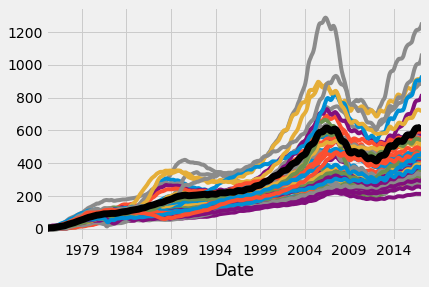

In [48]:
plt.clf()

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

HPI_percent_data.plot(ax=ax1)
HPI_bench.plot(color='k', ax=ax1, linewidth=7)

plt.legend().remove()
plt.show()

Looking at this data, it's pretty clear that the national average index follows the overall trend. There is mean variance across certain markets (notice the outliers above and below). This deviation from the mean appears to increase with respect to time as well. In 1975, the overall variance appears to be 200%, but present variance appears to be around 800%. This growth seems to have stayed constant since 2000s onward. 

##### Correlation:

It also could be incredibly useful to determine correlation between markets. Fortunately, Pandas has a function we can call on our dataframe to determine correlation. What this does for us is look at the historical prices for each state and determine the correlation between each and every other state's movement. From an investment perspective, we could view when two highly correlated markets start to diverge, purchase the rising market, short the falling market, under the perception that the two markets will eventually converge back.

In [ ]:
HPI_State_Correlation = HPI_data.corr()
print(HPI_State_Correlation)

This is pretty interesting. Most markets are pretty highly correlated (value close to 1). The lowest correlation is around the .75 mark, which is still relatively positive. This tells us, as a whole, the state markets tend to follow each other in a general trend. Whether they follow each other up or down would be a great question to ask as well. With this, we can now  look at opportunities where markets diverge from the national mean, but even based on movements from other states. We could invest in markets where the price falls by a standard deviation or sell when the price rises by a standard deviation as well. 

#### Transform the Data: 


Just for practice, I'm going to work on transform the data. This is fairly easy using pandas because of built in functions. We can re-sample by years, quarters, months, weeks, days, and even seconds (looking at you finance people). This can be a helpful practice to seasonally adjust series if need be. 

In [50]:
HPI_data['OR_SA'] = HPI_data['OR'].resample('A').mean()
HPI_data_SA = HPI_data['OR'].resample('A').mean()

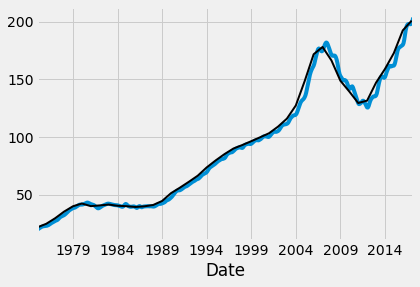

In [51]:
ax1 = plt.subplot2grid((1,1), (0,0))
HPI_data['OR'].plot(ax=ax1)
HPI_data_SA.plot(color="k", linewidth=2, ax=ax1)
plt.show()

### Handling missing data: 

While we don't have missing data sourced from Quandl, it's important to understand how to handle a situation when we are missing data points. There are multiple manners to handdle missing data:

* Ignore
* Delete 
* Fill forward or backwards
* Replace with static placeholder

Each reason can be utilized depending on your project goal. It depends on the context that is needed for handling missing data points. There could be a situation where ignoring your points, such as missing housing prices in our data series, that do not really affect our overall analysis. There could be other situations, such as understanding the missing bits or signals from a satalite, where the missing data points are imparative. 

##### Delete

In [52]:
HPI_data['OR_SA'].head()

Date
1975-01-31   NaN
1975-02-28   NaN
1975-03-31   NaN
1975-04-30   NaN
1975-05-31   NaN
Name: OR_SA, dtype: float64

In [ ]:
HPI_data.dropna(inplace=True)
print(HPI_data[['OR','OR_SA']].head())

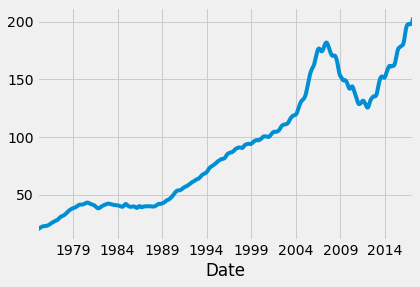

In [53]:
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

HPI_data['OR'].plot(ax=ax1)
HPI_data['OR_SA'].plot(ax=ax1, linewidth=2, color='k')

It's also helpful to note that we can specify __"how"__ we are to remove NaN data. `HPI_data.fillna(method='ffill',inplace=True)` specifies to drop NaN when the entire column is missing. Choose from 'any' or 'all'

##### Fill

Next up we have the ability to fill missing data. We can specify to fill from before or after, both with their inherent merits.

In [ ]:
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)

HPI_data['OR_SA'] = HPI_data['OR'].resample('A').mean()
HPI_data.fillna(method='ffill', inplace=True)
print(HPI_data[['OR','OR_SA']])

Fill forward:

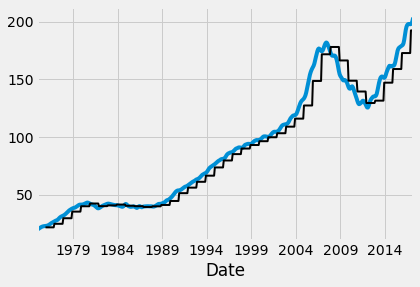

In [56]:
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

HPI_data['OR'].plot(ax=ax1)
HPI_data['OR_SA'].plot(ax=ax1, linewidth=2, color='k')
plt.show()

In [ ]:
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)

HPI_data['OR_SA'] = HPI_data['OR'].resample('A').mean()
HPI_data.fillna(method='bfill', inplace=True)
print(HPI_data[['OR','OR_SA']])

Fill Backward:

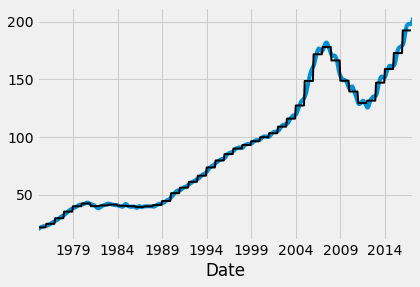

In [58]:
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

HPI_data['OR'].plot(ax=ax1)
HPI_data['OR_SA'].plot(ax=ax1, linewidth=2, color='k')
plt.show()

##### Replacing:

Our last step is to actually replace the data. In some cases, missing data can be sensitive to our analysis. To get around this, we can set the missing values to another value. Such as 0 or some other exorbitant number that is irrelevant. 

In [ ]:
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)

HPI_data['OR_SA'] = HPI_data['OR'].resample('A').mean()
HPI_data.fillna(value=-999999, inplace=True)
print(HPI_data[['OR','OR_SA']])

Granted in our case, this is a terrible move. For some cases, some models will automatically know that the abnormally low or high number is too extreme to be included, so it's automatically dropped. 

### Rolling Statistics

Another important tool for data analysis is __rolling statistics__. Most commonly used for moving averages, this operation allows us to calculate an average over a rolling period of time. In our case, we have monthly data. We can create a 10 moving average that would be the current value, plus the previous 9 values, averaged. Pandas comes with a built in moving average function - `rolling_apply()`:

In [ ]:
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)

HPI_data['OR_12MA'] = pd.rolling_mean(HPI_data['OR'], 12)

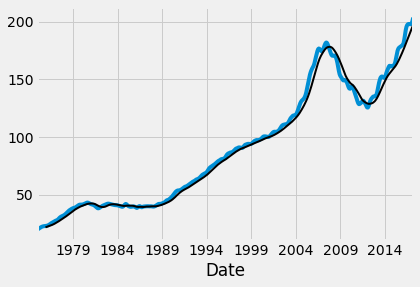

In [60]:
fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))

HPI_data['OR'].plot(ax=ax1)
HPI_data['OR_12MA'].plot(ax=ax1, linewidth=2, color='k')
plt.show()

We can actually produce a standard deviation rolling average as well: 

In [61]:
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)

HPI_data['OR_12MA'] = HPI_data['OR'].rolling(12).mean()
HPI_data['OR_STDMA'] = HPI_data['OR'].rolling(12).std()

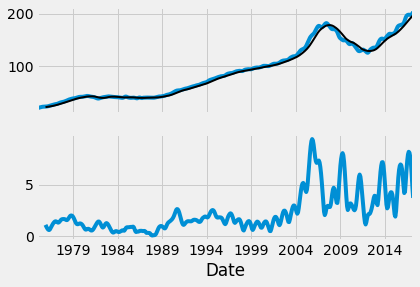

In [62]:
fig = plt.figure()
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

HPI_data['OR'].plot(ax=ax1)
HPI_data['OR_12MA'].plot(ax=ax1, linewidth=2, color='k')
HPI_data['OR_STDMA'].plot(ax=ax2)
plt.show()

Another interesting visualization would be to view the difference between Oregon HPI and National HPI. We can include a rolling correlation between them as well. 

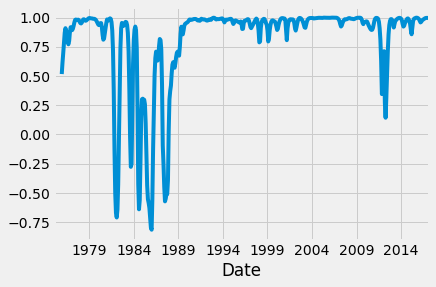

In [63]:
OR_ID_12corr = HPI_data['OR'].rolling(12).corr(HPI_data['ID'])
OR_ID_12corr.plot()

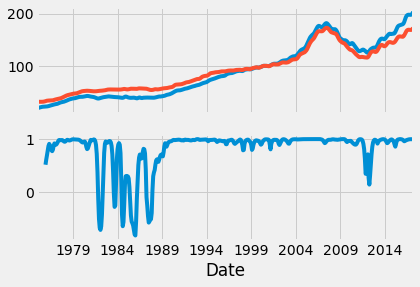

In [64]:
fid = plt.figure()
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


HPI_data['OR'].plot(ax=ax1, label='OR HPI')
HPI_data['ID'].plot(ax=ax1, label='ID HPI')


OR_ID_12corr.plot(ax=ax2)
plt.show()

This is great, and in theory, we can build a strategy upon this. As the correlation drops, you would sell the market that is rising and purchase the market that is falling. Under the hope that the two will merge back to each other. The Oregon market and the Idaho market are so correlated, that when the correlation drops down to -.5, we can be extremely confident that the two markets will converge back. 

### Interest Rates:

So given this, we could develop a pretty safe investing strategy around the divergence of highly correlated markets. We can incorporate interest rates:

In [ ]:
df = quandl.get("FMAC/MORTG", trim_start="1975-01-01", authtoken=api_key)
df['Value'] = (df['Value'] - df['Value'][0]) / df['Value'][0] * 100.00
df = df.resample("M").mean()
print(df.head())
df.plot()

In [ ]:
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)

### Additional Economic Indicators 

For additional analysis, we can also utilize interest rates. We'll import the 30 year conventional mortgage rate from Freddie Mac. In theory, it should be negatively correlated with HPI. 

In [17]:
def mort_rate_30y():
    rate_30 = pd.DataFrame()
    rate_30 = quandl.get("FMAC/MORTG", trim_start='1975-01-01', authtoken=api_key)
    rate_30['Value'] = (rate_30['Value'] - rate_30['Value'][0]) / rate_30['Value'][0] * 100.00
    rate_30 = rate_30.resample('1D').mean()
    rate_30 = rate_30.resample('M').mean()
    rate_30.columns = ['rate_30']

    return rate_30

In [18]:
#Creating a new national HPI dataframe containing 30 year interest rate
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)
interest_rate = mort_rate_30y()
HPI_bench = HPI_benchmark()
HPI = HPI_bench.join(interest_rate)

In [96]:
print(HPI.corr())

               United States   rate_30
United States       1.000000 -0.778423
rate_30            -0.778423  1.000000


This correlation gives us a pretty good idea for the inverse correlation between interest rates and the housing prices.

In [19]:
HPI_state_rate = HPI_data.join(interest_rate)
print(HPI_state_rate.corr()['rate_30'].describe())

count    51.000000
mean     -0.738510
std       0.251955
min      -0.827181
25%      -0.799160
50%      -0.787297
75%      -0.757113
max       1.000000
Name: rate_30, dtype: float64


Its pretty interesting to note the lack of variance across all of these markets. Our mean correlation is -.738, with is pretty close to the national correlation with interest rates at -.7784. Our standard deviation is only .252 as well. Next up we'll add GDP into our analysis to control for macro conditions. 

In [20]:
def GDP_data():
    df = pd.DataFrame()
    df = quandl.get("BEA/GDP", trim_start = '1975-01-01', authtoken=api_key)
    df.rename(columns={'GDP in billions of current dollars':'GDP'}, inplace=True)
    df['GDP'] = (df['GDP'] - df['GDP'][0]) / df['GDP'][0] * 100.00
    df = df.resample('M').mean()
    df.fillna(method='ffill', inplace=True)
    df = df['GDP']

    return df

In [21]:
def sp500_data():
    df = pd.DataFrame()
    df = quandl.get('YAHOO/INDEX_GSPC', trim_start='1975-01-01', authtoken=api_key, collapse='monthly')
    df['Adjusted Close'] = (df['Adjusted Close'] - df['Adjusted Close'][0]) / df['Adjusted Close'][0] * 100.00
    df.rename(columns={'Adjusted Close':'sp500'}, inplace=True)
    df = df['sp500']
    return df

In [22]:
def us_unemployment():
    df = quandl.get("ECPI/JOB_G", trim_start='1975-01-01', authtoken=api_key)
    df['Unemployment Rate'] = (df['Unemployment Rate'] - df['Unemployment Rate'][0]) / df['Unemployment Rate'][0] * 100.00
    df = df.resample('1D').mean()
    df = df.resample('M').mean()
    return df

In [23]:
pickle_in = open("states_housing_index.pickle", "rb")
HPI_data = pickle.load(pickle_in)
interest_rate = mort_rate_30y()
HPI_bench = HPI_benchmark()
GDP = GDP_data()
sp500 = sp500_data()
unemployment = us_unemployment()

HPI_small = HPI_bench.join([interest_rate,sp500,GDP,unemployment])
HPI_small.dropna(inplace=True)
print(HPI_small.corr())

HPI_full = HPI_data.join([interest_rate,HPI_bench,sp500,GDP,unemployment])
HPI_full.dropna(inplace=True)
HPI_full.to_pickle('HPI.pickle')

                     US_HPI   rate_30     sp500       GDP  Unemployment Rate
US_HPI             1.000000 -0.737607  0.890928  0.957717          -0.273880
rate_30           -0.737607  1.000000 -0.760843 -0.799024           0.290630
sp500              0.890928 -0.760843  1.000000  0.915268          -0.416431
GDP                0.957717 -0.799024  0.915268  1.000000          -0.174838
Unemployment Rate -0.273880  0.290630 -0.416431 -0.174838           1.000000


Taking a look at these numbers, its pretty clear that housing prices are highly correlated with the GDP and the S&P 500. Sadly, unemployment rate is fairly weakly correlated, which is surprising. One would think, that if someone is unemployed, they would find it difficult to purchase or finance a home, but the short term qualities of unemployment probably should be controlled for. Moving forward, we will utilize GDP and the interest rate to see if they have predictive values for housing prices. 

## Forecasting Housing Prices: 

While this project isn't focused specifically on machine learning, it posses a wonderful opportunity to test some out. This is an intro, and by no mean comprehensive display of ML. We can utilize mapping features for mapping our previous data frames to get them ready to __teach__ our machine. We will be using the Numpy library for help. Our goal is to predict changes in housing prices. 

We can classify the current HPI values, compare them to two months ahead. If they went up or down, we can classify them and then set an entire month to a feature set, with the goal of utilizing these to predict future housing prices. 

In [24]:
import numpy as np

In [25]:
HPI = pd.read_pickle("HPI.pickle")
HPI = HPI.pct_change()
HPI.replace([np.inf, -np.inf], np.nan, inplace=True)
HPI.dropna(inplace=True)

HPI['US_HPI_forecast'] = HPI['US_HPI'].shift(-1)

Now we can create a function map to run over out entire data set. This is going to show: if the future housing prices was greater than the current price, record that as a 1, else, record that as a 0.

In [26]:
def forecast_labels(current_HPI, future_HPI):
    if future_HPI > current_HPI:
        return 1
    else:
        return 0

In [27]:
HPI['label'] = list(map(forecast_labels, HPI['US_HPI'], HPI['US_HPI_forecast']))

Now that we have our labels, we can import SciKit-Learn to try to forecast future prices. Since now that we have our features (GDP, interest rates, benchmarks, etc) and labels, we're ready to roll.

In [ ]:
from sklearn import svm, preprocessing, cross_validation

In [46]:
X = np.array(HPI.drop(['label','US_HPI_forecast'], 1))
y = preprocessing.scale(X)
y = np.array(HPI['label'])
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
print(clf.score(X_test, y_test))

0.464285714286


So this means are model is aroun 45-55% accurate. I wouldn't say thats very ground breaking, but there are a bunch of other things we can do to adjust our model. I'll keep that for further projects though 